##Mount Google Drive

In [1]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


##Set up root

In [2]:
# Specify the directory path
root = '/gdrive/MyDrive/Irfan/ESC-50-master'
!ls '/gdrive/MyDrive/Irfan/ESC-50-master'

 audio		    esc50.gif   melspectrograms   pytest.ini   requirements.txt
'audio augmented'   LICENSE     meta		  README.md    tests


##Import Libraries

In [3]:
from keras.applications.xception import Xception, preprocess_input #CHANGE THIS TO DIFFERENT MODEL
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.applications.vgg16 import preprocess_input
from matplotlib import pyplot as plt
import numpy as np
import json as js

##Set Parameter Values

In [4]:
batch_size = 32
epochs = 100

# dimensions of our images.
img_width, img_height = 224, 224

input_tensor = Input(shape=(224,224,3))

nb_training_samples = 1600
nb_validation_samples = 400# Set parameter values

##Data Loader

In [5]:
# training generator configuration
training_data_dir = root + '/audio augmented/training'

training_datagen = image.ImageDataGenerator(
    rescale=1./255)

training_generator = training_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

# validation generator configuration
validation_data_dir = root + '/audio augmented/testing/'

validation_datagen = image.ImageDataGenerator(
    rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 4800 images belonging to 50 classes.
Found 1200 images belonging to 50 classes.


##Base Model

In [6]:
base_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor) #CHANGE THIS TO THE NAME OF THE MODEL
base_model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

##Top Model

In [7]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(50, activation='softmax')) #CHANGE HERE FOR THE AMOUNT OF CLASS
top_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12850     
Total params: 25,703,218
Trainable params: 25,703,218
Non-trainable params: 0
_________________________________________________________________


##Base + Top

In [8]:
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

##Training configuration

In [9]:
from keras import metrics, optimizers

num_layers_to_freeze = 15

def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

for layer in model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy', top_5_accuracy])

# serialize model to JSON
model_json = model.to_json()
model_filename = "vgg16_model_{}_frozen_layers.json".format(num_layers_to_freeze)
with open(model_filename, "w") as json_file:
    json_file.write(model_json)


##Training Pipeline

Epoch 1/100
50/50 [==============================] - 430s 8s/step - loss: 3.9906 - accuracy: 0.0303 - top_5_accuracy: 0.1265 - val_loss: 3.8693 - val_accuracy: 0.0529 - val_top_5_accuracy: 0.1947

Epoch 00001: val_accuracy improved from -inf to 0.05288, saving model to /gdrive/MyDrive/Irfan/ckpts/Xception.best.hdf5
Epoch 2/100
50/50 [==============================] - 326s 7s/step - loss: 3.7076 - accuracy: 0.1013 - top_5_accuracy: 0.2809 - val_loss: 3.7069 - val_accuracy: 0.0817 - val_top_5_accuracy: 0.2332

Epoch 00002: val_accuracy improved from 0.05288 to 0.08173, saving model to /gdrive/MyDrive/Irfan/ckpts/Xception.best.hdf5
Epoch 3/100
50/50 [==============================] - 162s 3s/step - loss: 3.4984 - accuracy: 0.1375 - top_5_accuracy: 0.3698 - val_loss: 3.5325 - val_accuracy: 0.1394 - val_top_5_accuracy: 0.3462

Epoch 00003: val_accuracy improved from 0.08173 to 0.13942, saving model to /gdrive/MyDrive/Irfan/ckpts/Xception.best.hdf5
Epoch 4/100
50/50 [========================

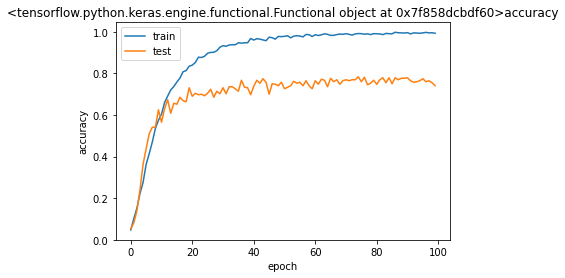

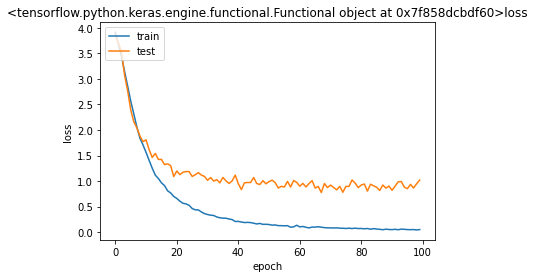

>Saved /gdrive/MyDrive/Irfan/models/h5/Xception.h5


In [10]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from time import time

tensorboard = TensorBoard(log_dir="logs/layers_frozen_{}".format(num_layers_to_freeze))

# checkpoint
filepath= "/gdrive/MyDrive/Irfan/ckpts/Xception.best.hdf5" #CHANGE THIS TOO
best_model_checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [best_model_checkpoint, tensorboard]


history = model.fit(
    training_generator,
    steps_per_epoch=nb_training_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
    callbacks=callbacks_list)

# evaluate the model
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
print('%s train accuracy: %.3f, %s test accuracy: %.3f' % (model, train_acc[0], model, test_acc[0]))

#plotting accuracy
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title(str(model) + 'accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plotting loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title(str(model) + 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

filename = '/gdrive/MyDrive/Irfan/models/h5/Xception.h5' #CHANGE THIS
model.save(filename)
print('>Saved %s' % filename)

##Top K Prediction

In [11]:
def get_top_k_predictions(preds, label_map, k=5, print_flag=False):
    sorted_array = np.argsort(preds)[::-1]
    top_k = sorted_array[:k]
    label_map_flip = dict((v,k) for k,v in label_map.items())
    
    y_pred = []
    for label_index in top_k:
        if print_flag:
            print("{} ({})".format(label_map_flip[label_index], preds[label_index]))
        y_pred.append(label_map_flip[label_index])
        
    return y_pred

In [12]:
label_map = (training_generator.class_indices)
 
json = js.dumps(label_map)
f = open("cough_label_map.json","w")
f.write(json)
f.close()

img_path = root + '/melspectrograms/testing/vacuum_cleaner/1-19872-A-36.png'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)* 1./255

preds = model.predict(x)[0]

get_top_k_predictions(preds, label_map, k=3)

['vacuum_cleaner', 'washing_machine', 'helicopter']

##Confusion Matrix

In [13]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(24,24))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


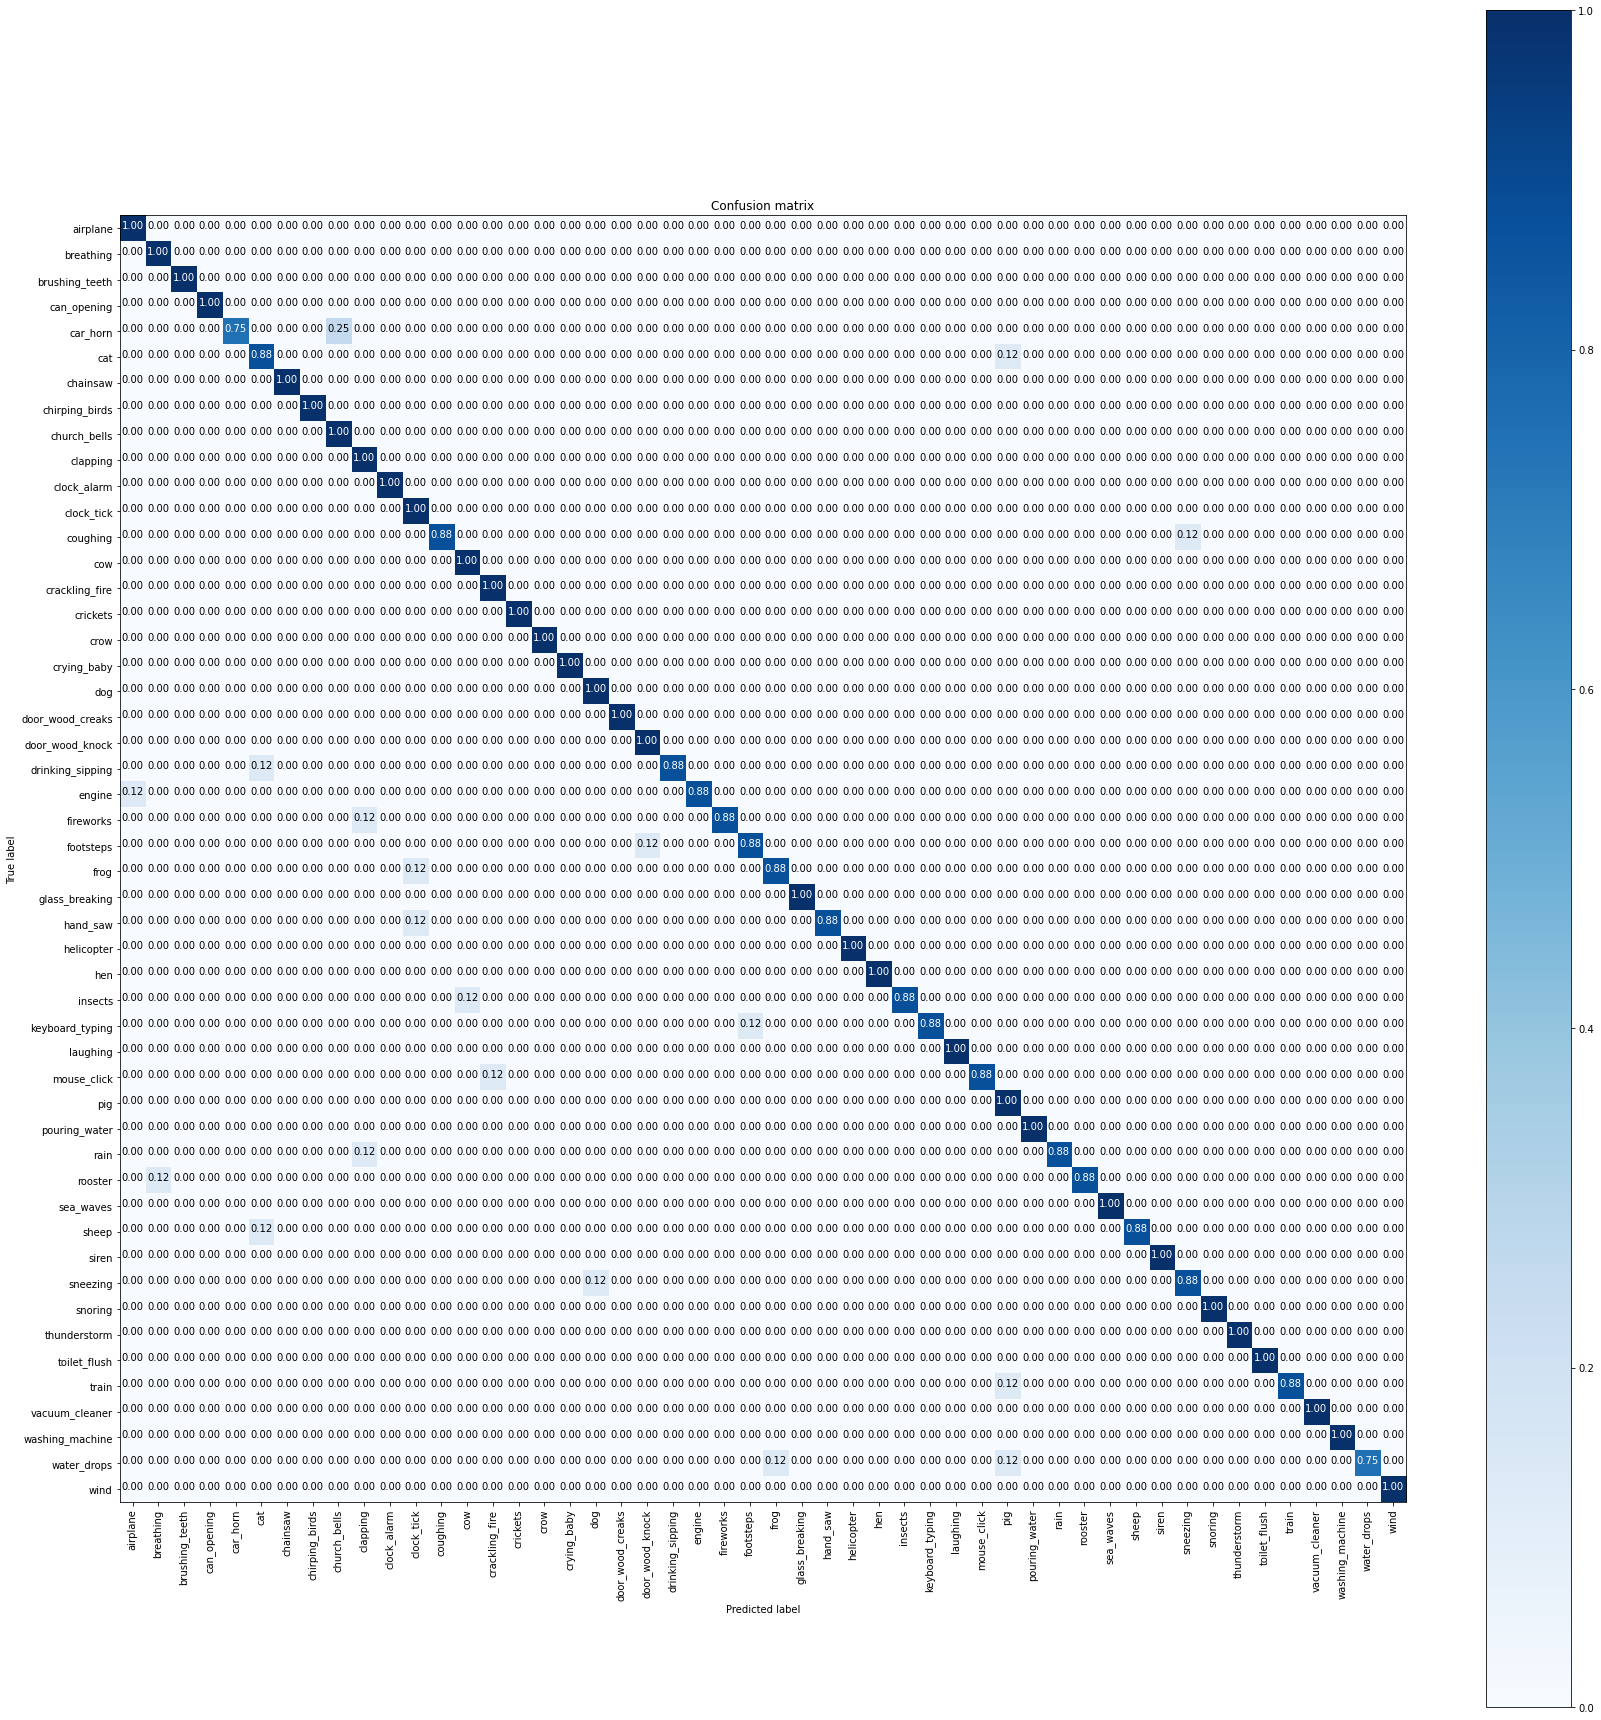

In [14]:
import os
from sklearn.metrics import confusion_matrix

testing_dir = root + '/melspectrograms/testing/'

y_true = []
y_pred = []
for label in label_map.keys():
    file_list = os.listdir(testing_dir + label)
    for file_name in file_list:
        img_path = testing_dir + label + '/' + file_name
        
        img = image.load_img(img_path, target_size=(224, 224))
        
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)* 1./255
        
        preds = model.predict(x)[0]
        
        y_true.append(label)
        y_pred.append(get_top_k_predictions(preds, label_map, k=1)[0])
        
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, sorted(label_map.keys()), normalize=True)